# Segmenting Spotify Users Into Different Clusters

By: Rommel Artola </br>
Data Source: https://www.kaggle.com/datasets/meeraajayakumar/spotify-user-behavior-dataset/data

### Data Legend/Columns:
* Age - Age group of user?
* ender - Gender of user?
* potify_usage_period - How long have you been using Spotify?
* potify_listening_device - Which of the following devices do you primarily use to listen to Spotify?
* potify_subscription_plan - Which Spotify subscription plan do you currently have?
* remium_sub_willingness - Are you willing to take a premium subscription or willing to continue with premium subscription in future?
* reffered_premium_plan - If premium or willing to take premium, what amount do you pay for the subscription?
* referred_listening_content - What do you prefer to listen more?
* av_music_genre - What genre(s) of music do you enjoy the most?
* music_time_slot - What is your favourite time slot to listen to music?
* music_Influencial_mood - When it comes to listening to music, which of the following moods or situations most strongly influences your choice of* ic?
* music_lis_frequency - When do you listen to music more often?
* music_expl_method - How do you discover new music on Spotify?
* music_recc_rating - How do you rate the spotify music recommendations?
* pod_lis_frequency - How often do you listen to Podcast?
* fav_pod_genre - What genre(s) of Podcast do you enjoy the most?
* preffered_pod_format - What podcast format you generally prefer?
* pod_host_preference - Are you more inclined to listen to podcasts from unknown personalities, or do you prefer podcasts hosted by well-known individuals?
* preffered_pod_duration - Do you prefer shorter podcast episodes (under 30 minutes) or longer episodes (over 30 minutes)
* pod_variety_satisfaction - Are you satisfied with the variety and availability of podcasts on Spotify?


### About the Datafile (from the Data's author)
"The Spotify User Behavior Dataset is a comprehensive collection of anonymized data that offers valuable insights into the behavior patterns and preferences of Spotify users. This primary dataset is specifically designed for analyzing user interactions, music consumption habits, and engagement metrics within the Spotify music streaming platform. It provides researchers, data analysts, and data scientists with a rich resource to explore and understand user behavior in depth."

In [130]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = None

In [5]:
# Setting Repo Paths
# Set project paths
repo = os.path.abspath('')
data_file = os.path.join(repo, 'Data', 'Spotify_data.xlsx')

In [6]:
df_source = pd.read_excel(data_file)

Let's get a very quick view at the countplots of each data columns before we start any analysis.

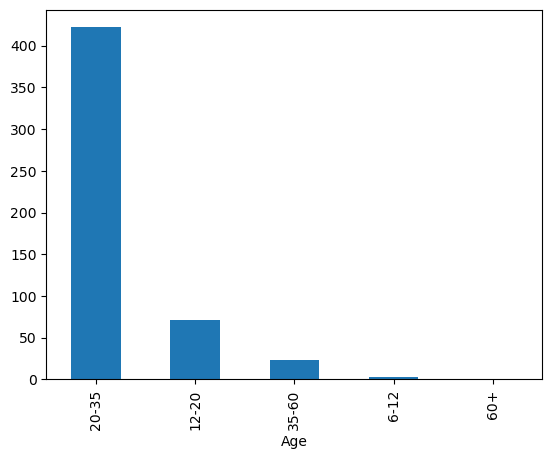

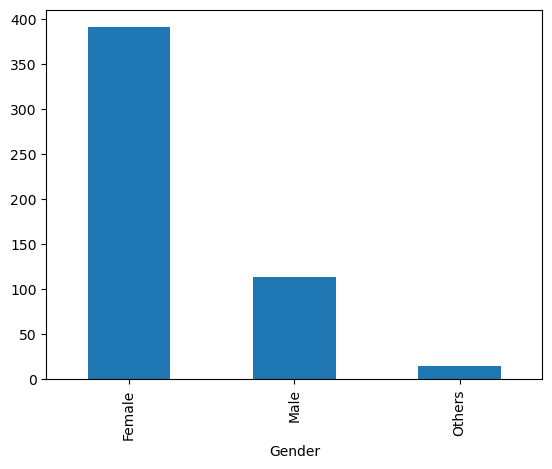

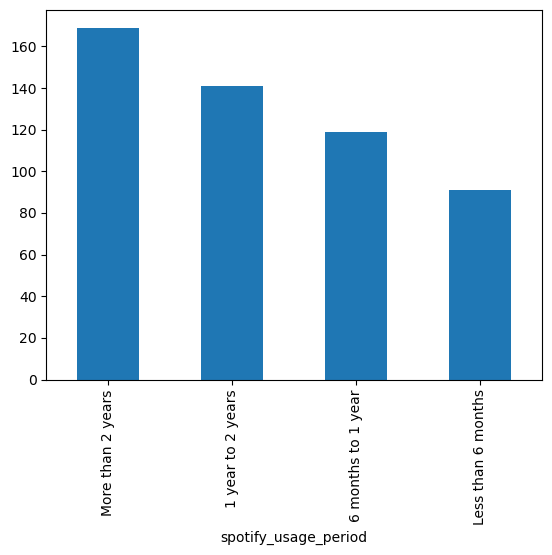

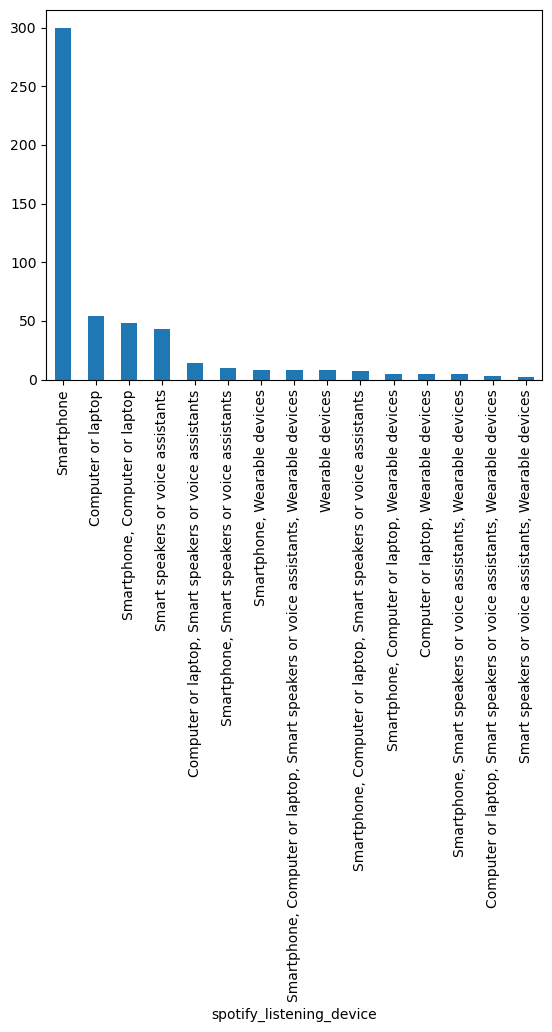

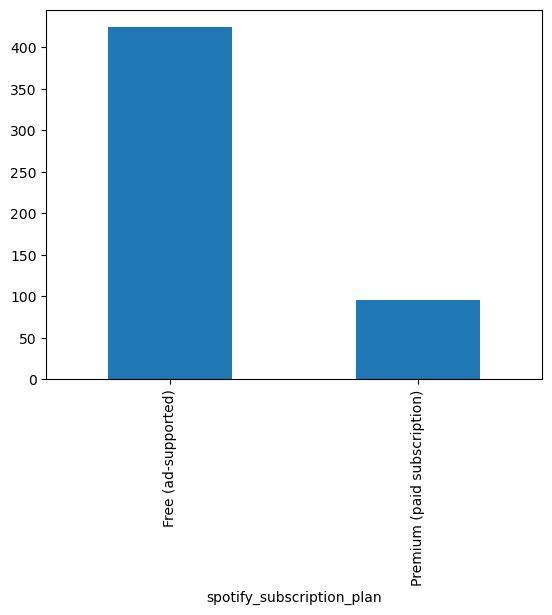

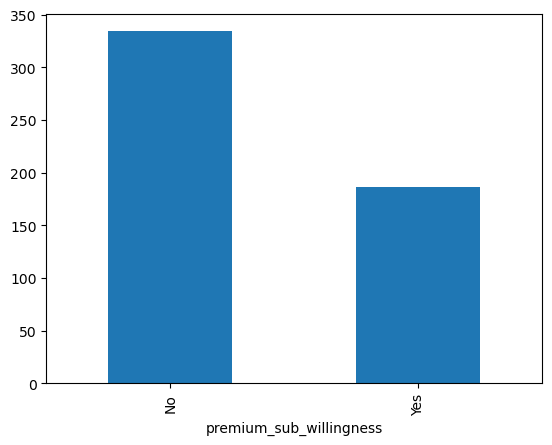

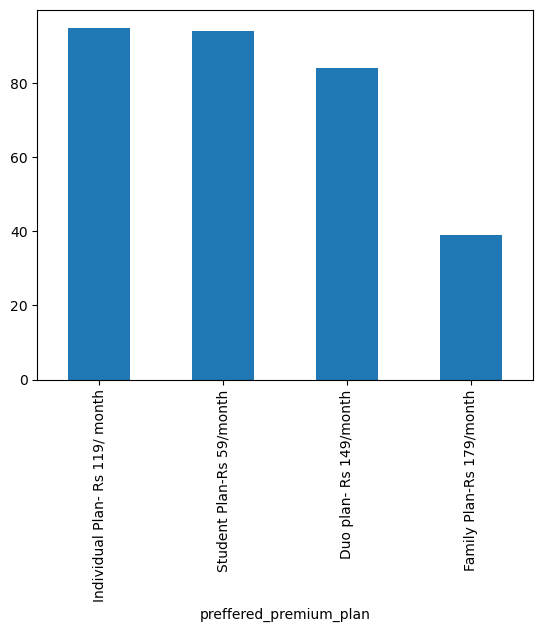

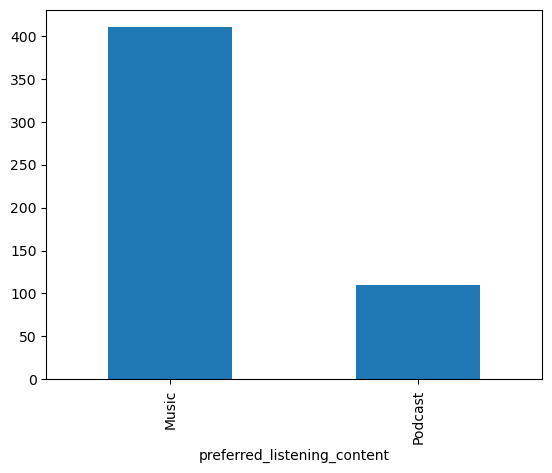

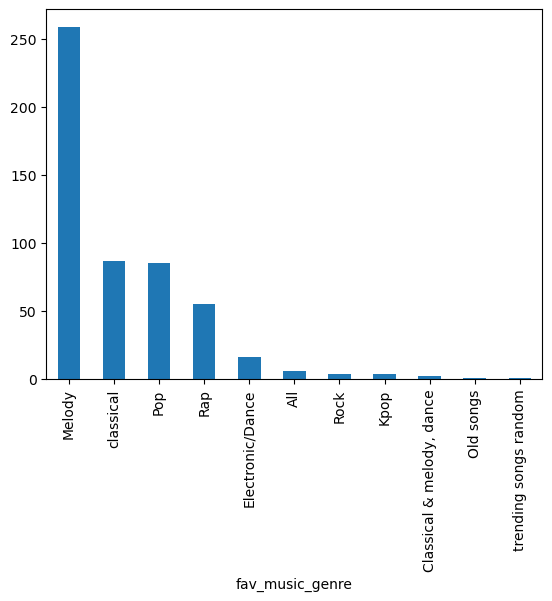

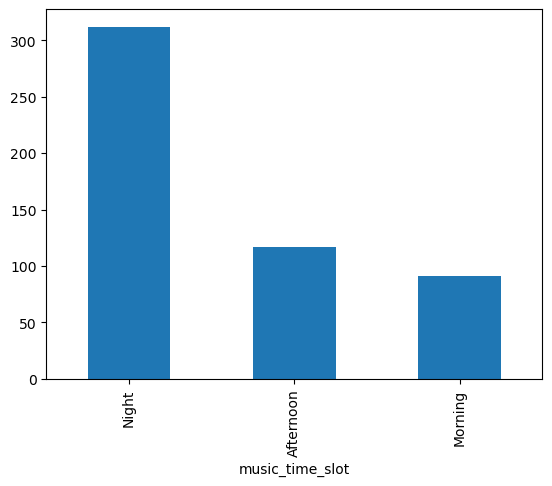

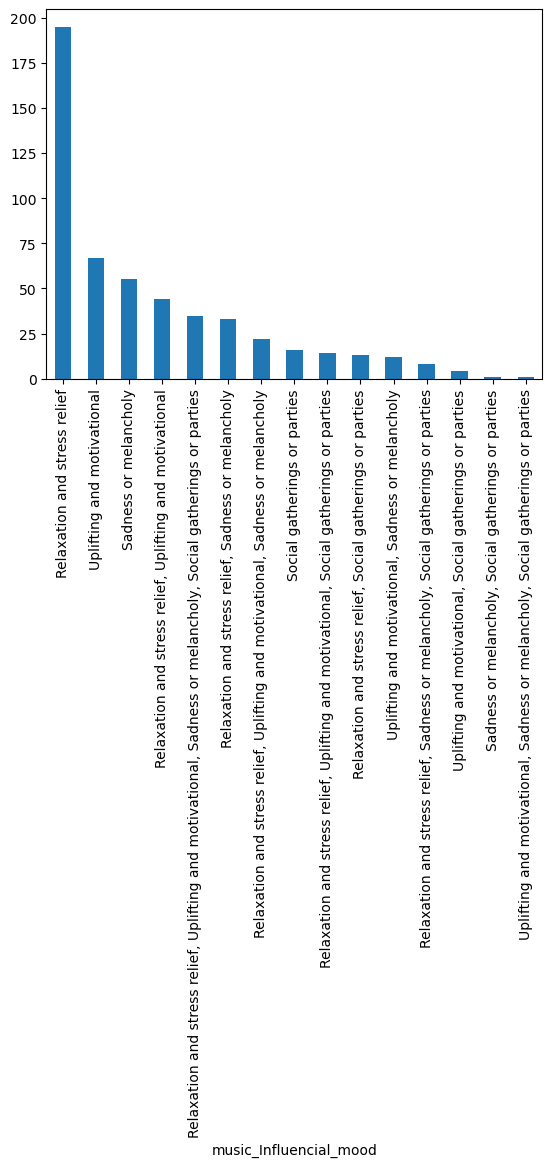

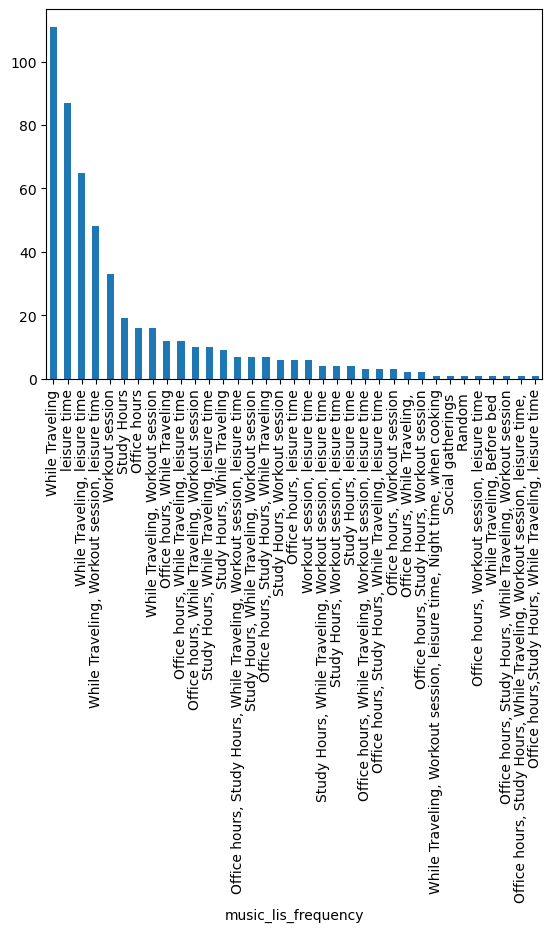

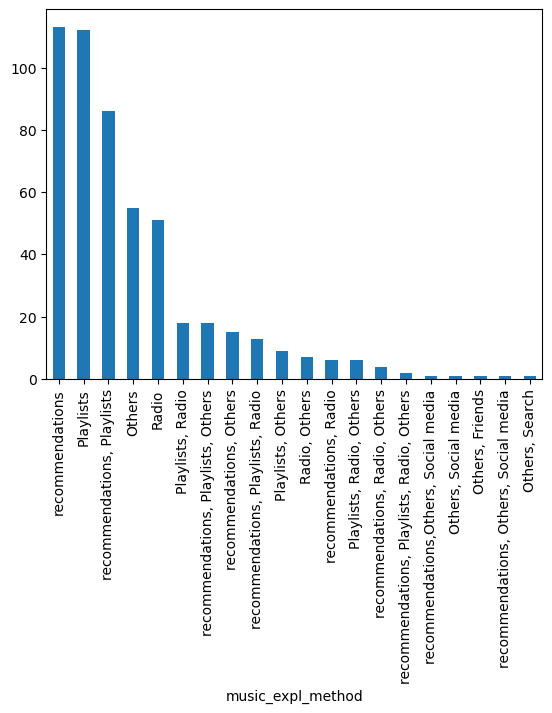

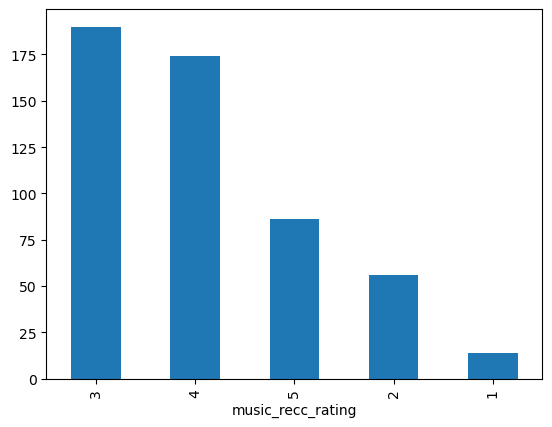

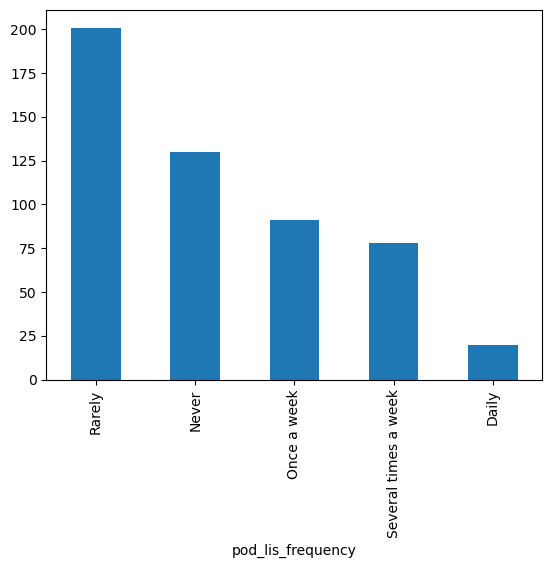

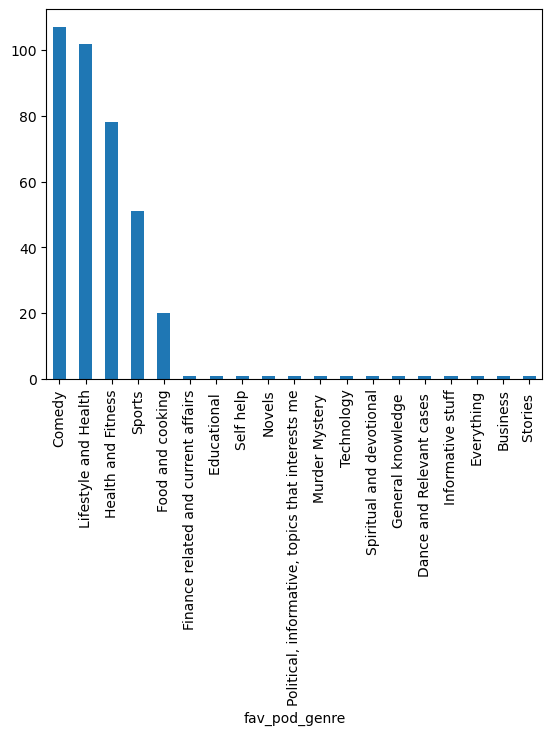

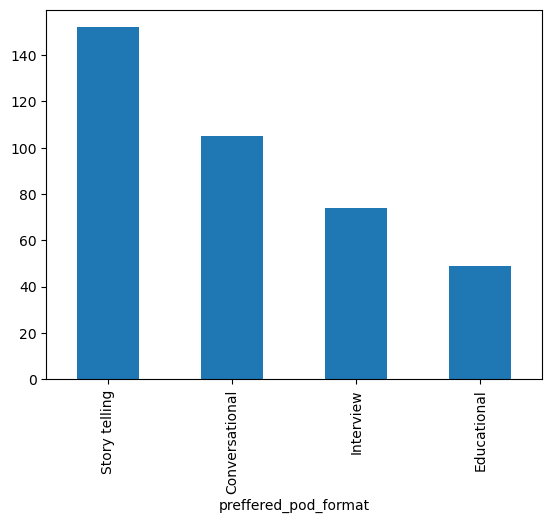

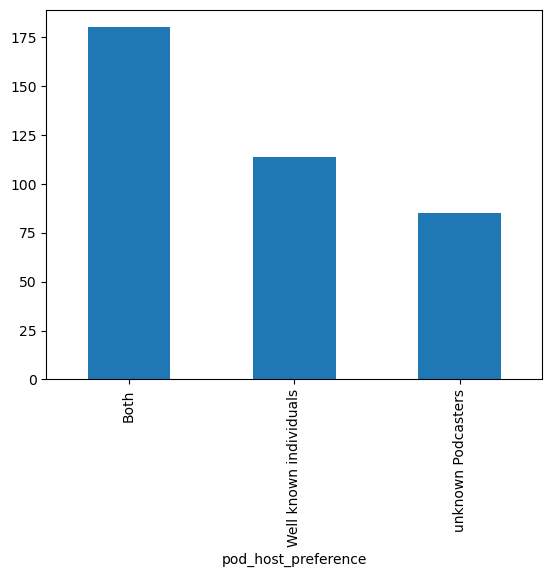

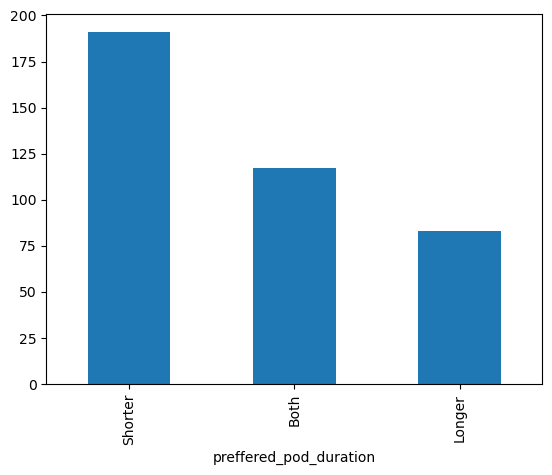

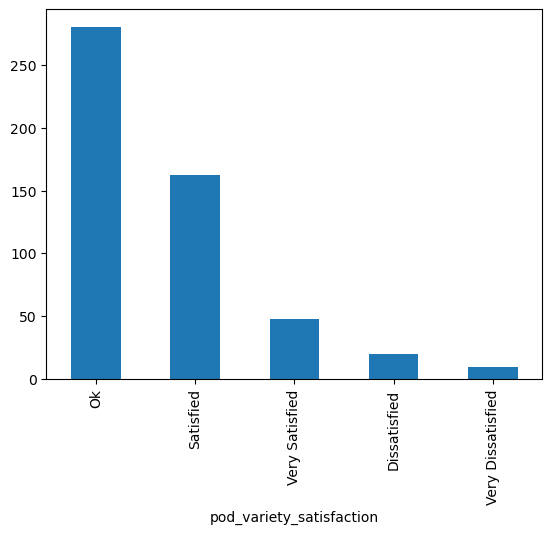

In [ ]:
for col in df_source.columns.tolist():
    df_source[col].value_counts().plot(kind='bar')
    plt.show()

We do see a few columns/values that have much stronger representation than the rest, so this will likely bias our segmentation a bit. However, this should still provide a good segmentation because it should cluster all of those dispropotionate counts respectively, as long as we select an appropriate k-number of clusters (users to segment).

Let's now look at data quality (how many NAs, etc).

In [16]:
df_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

Here, we can see that a few columns (preffered_premium_plan, fav_pod_genre, preffered_pod_format, pod_host_preference, etc..) have missing values. One could simply drop this columns, but then we would be obscurring a lot of value in relation to podcast. So, since these values are NAs and they are all relating to Podcasts, one could make the assumption that these values are missing because they are not Podcast enjoyers. So, let's fill those values in with that manual override.

For that, we first need to make safe assumptions about the presumed value we could fill it in. And we can only do that by analyzing column pairs individually.

Now, for time's sake, this section is skipped simply because it's printing through several table logics with some NAs and asserting a value based on values of other related columns Needless to say, this process was very iterative, messy, and not very presentable. So, instead, just see the end/resulting logic in the new dataframe. Essentially, any NAs on preferred premium plans were filled with No Choice if they were not willing.

And for the podcasts, if there was no pod_lis_frequency, they simply were classified as Not A Podcast Listener. This way, we can keep all of these columns.

It seems that some errors in data or survey results are happening. So, so simplify some of this and keep it consistent, for any values of "Never" in pod listening frequency, we will make sure to list the answer as Not A Podcast Listener. 

After this initial cleaning, there were still some NAs, so we filled those missing NAs with a simple 'No Answer' value.

In [66]:
# Convenience function for the podcast cleaning.
def pod_cleaner(pod_lis_frequency:pd.Series, col_to_clean:pd.Series):
    ret = np.where(pod_lis_frequency == 'Never', 'Not a Podcast Listener', col_to_clean)
    return ret

In [75]:
df_clean = (
    df_source
    .assign(
        preffered_premium_plan = lambda df: np.where(df['preffered_premium_plan'].isna(), 'No Preference or Willingness', df['preffered_premium_plan']),
        fav_pod_genre = lambda df: pod_cleaner(df['pod_lis_frequency'], df['fav_pod_genre']),
        preffered_pod_format = lambda df: pod_cleaner(df['pod_lis_frequency'], df['preffered_pod_format']),
        pod_host_preference = lambda df: pod_cleaner(df['pod_lis_frequency'], df['pod_host_preference']),
        preffered_pod_duration = lambda df: pod_cleaner(df['pod_lis_frequency'], df['preffered_pod_duration']),
    )
    .fillna(
        {col: 'No Answer' for col in ['fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration']}
    )
)

In [80]:
df_clean.isna().any(axis=0).any() 
# Now we've got no NAs anywhere.

False

Now, we will need to create custom label encoding for a lot of our features which have a natural ordinal nature to them. We could automate this using LabelEncoder, but it does not guarantee our ideal order of values. So, we will need to create custom mapping dictionaries.

Once again, the below was created through various iterative searches that would be overly redundant to showcase. In simple terms, any data point with an ordinal sense, we turned it into a manual labelencoded to make sure we know the ordinal nature of the data. And any data with no ordinal logic, we turned it into a one-hone encoding. Some of these one-hot were manual (like Gender), and the other were left up to pandas get_dummies() method.

In [150]:
age_mapper = {
    '6-12': 0,
    '12-20': 1,
    '20-35': 2,
    '35-60': 3,
    '60+': 4,
}

usage_mapper = {
    'Less than 6 months': 0,
    '6 months to 1 year': 1,
    '1 year to 2 years': 2,
    'More than 2 years': 3,
}

premium_plan_mapper = {
    'No Preference or Willingness': 0,
    'Student Plan-Rs 59/month': 1,
    'Individual Plan- Rs 119/ month': 2,
    'Duo plan- Rs 149/month': 3,
    'Family Plan-Rs 179/month': 4,
}

pod_list_freq_mapper = {
    'Never': 0,
    'Rarely': 1,
    'Once a week': 2,
    'Several times a week': 3,
    'Daily': 4
}


pod_variety_mapper = {
    'Very Dissatisfied': 0,
    'Dissatisfied': 1,
    'Ok': 2,
    'Satisfied': 3,
    'Very Satisfied': 4,
}

cols_to_drop = ['Age', 'Gender', 'spotify_usage_period', 'premium_sub_willingness', 'spotify_subscription_plan', 'preffered_premium_plan',
                'preferred_listening_content', 'pod_variety_satisfaction', 'pod_lis_frequency',
                ]

cols_for_dummies = ['spotify_listening_device', 'fav_music_genre', 'music_time_slot', 'music_Influencial_mood', 
                    'music_lis_frequency', 'music_expl_method', 'fav_pod_genre', 'preffered_pod_format', 
                    'pod_host_preference', 'preffered_pod_duration', 
                    ]
df = (
    df_clean
    .assign(
        Age_Encoded = lambda df: df['Age'].map(age_mapper),
        Is_Female = lambda df: np.where(df['Gender'] == 'Female', 1, 0),
        Usage_Period_Encoded = lambda df: df['spotify_usage_period'].map(usage_mapper),
        Is_Paying_Member = lambda df: np.where(df['spotify_subscription_plan'] == 'Premium (paid subscription)', 1, 0),
        Willing_Sub_Premium = lambda df: np.where(df['premium_sub_willingness'] == 'Yes', 1, 0),
        Premium_Plan_Encoded = lambda df: df['preffered_premium_plan'].map(premium_plan_mapper),
        Prefers_Music = lambda df: np.where(df['preferred_listening_content']=='Music', 1, 0),
        Pod_Frequency_Encoded = lambda df: df['pod_lis_frequency'].map(pod_list_freq_mapper),
        Pod_Variety_Satis_Encoded = lambda df: df['pod_variety_satisfaction'].map(pod_variety_mapper)
    )
    .pipe(
        lambda df: pd.get_dummies(df, drop_first=True, columns=cols_for_dummies)
    )
    .drop(columns=cols_to_drop)
    .astype(int)
)

df.head()

,music_recc_rating,Age_Encoded,Is_Female,Usage_Period_Encoded,Is_Paying_Member,Willing_Sub_Premium,Premium_Plan_Encoded,Prefers_Music,Pod_Frequency_Encoded,Pod_Variety_Satis_Encoded,"spotify_listening_device_Computer or laptop, Smart speakers or voice assistants","spotify_listening_device_Computer or laptop, Smart speakers or voice assistants, Wearable devices","spotify_listening_device_Computer or laptop, Wearable devices",spotify_listening_device_Smart speakers or voice assistants,"spotify_listening_device_Smart speakers or voice assistants, Wearable devices",spotify_listening_device_Smartphone,"spotify_listening_device_Smartphone, Computer or laptop","spotify_listening_device_Smartphone, Computer or laptop, Smart speakers or voice assistants","spotify_listening_device_Smartphone, Computer or laptop, Smart speakers or voice assistants, Wearable devices","spotify_listening_device_Smartphone, Computer or laptop, Wearable devices","spotify_listening_device_Smartphone, Smart speakers or voice assistants","spotify_listening_device_Smartphone, Smart speakers or voice assistants, Wearable devices","spotify_listening_device_Smartphone, Wearable devices",spotify_listening_device_Wearable devices,"fav_music_genre_Classical & melody, dance",fav_music_genre_Electronic/Dance,fav_music_genre_Kpop,fav_music_genre_Melody,fav_music_genre_Old songs,fav_music_genre_Pop,fav_music_genre_Rap,fav_music_genre_Rock,fav_music_genre_classical,fav_music_genre_trending songs random,music_time_slot_Morning,music_time_slot_Night,"music_Influencial_mood_Relaxation and stress relief, Sadness or melancholy","music_Influencial_mood_Relaxation and stress relief, Sadness or melancholy, Social gatherings or parties","music_Influencial_mood_Relaxation and stress relief, Social gatherings or parties","music_Influencial_mood_Relaxation and stress relief, Uplifting and motivational","music_Influencial_mood_Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy","music_Influencial_mood_Relaxation and stress relief, Uplifting and motivational, Sadness or melancholy, Social gatherings or parties","music_Influencial_mood_Relaxation and stress relief, Uplifting and motivational, Social gatherings or parties",music_Influencial_mood_Sadness or melancholy,"music_Influencial_mood_Sadness or melancholy, Social gatherings or parties",music_Influencial_mood_Social gatherings or parties,music_Influencial_mood_Uplifting and motivational,"music_Influencial_mood_Uplifting and motivational, Sadness or melancholy","music_Influencial_mood_Uplifting and motivational, Sadness or melancholy, Social gatherings or parties","music_Influencial_mood_Uplifting and motivational, Social gatherings or parties","music_lis_frequency_Office hours, Study Hours, While Traveling","music_lis_frequency_Office hours, Study Hours, While Traveling, Workout session","music_lis_frequency_Office hours, Study Hours, While Traveling, Workout session, leisure time","music_lis_frequency_Office hours, Study Hours, While Traveling, Workout session, leisure time,","music_lis_frequency_Office hours, Study Hours, While Traveling, leisure time","music_lis_frequency_Office hours, Study Hours, Workout session","music_lis_frequency_Office hours, While Traveling","music_lis_frequency_Office hours, While Traveling,","music_lis_frequency_Office hours, While Traveling, Workout session","music_lis_frequency_Office hours, While Traveling, Workout session, leisure time","music_lis_frequency_Office hours, While Traveling, leisure time","music_lis_frequency_Office hours, Workout session","music_lis_frequency_Office hours, Workout session, leisure time","music_lis_frequency_Office hours, leisure time","music_lis_frequency_Office hours,Study Hours, While Traveling, leisure time",music_lis_frequency_Random,music_lis_frequency_Social gatherings,music_lis_frequency_Study Hours,"music_lis_frequency_Study Hours, While Traveling","music_lis_frequency_Study Hours, While Traveling, Workout session","music_lis_frequen

In [ ]:
df.isna().any().any() # No NAs in our mappings/encoding.

False

# K-Means

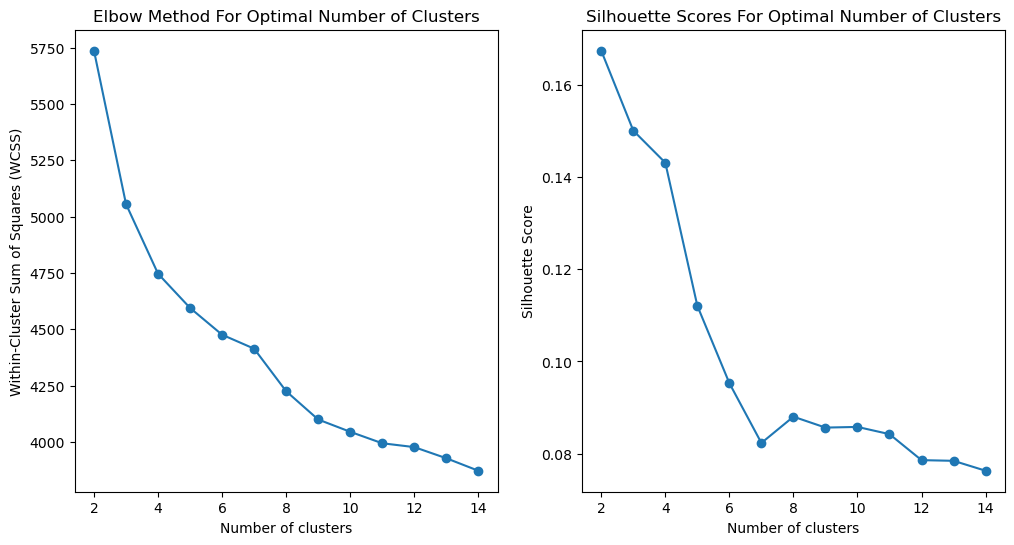

In [156]:
inertias = []
sil_scores = []
test_range = range(2,15)

for k in test_range:
    K_ML = KMeans(n_clusters=k, random_state=777)
    labels = K_ML.fit_predict(X=df)

    inertias.append(K_ML.inertia_)

    sil_score = silhouette_score(X=df, labels=K_ML.labels_)
    sil_scores.append(sil_score)


fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 6))

# Plot the Elbow Method
ax[0].plot(test_range, inertias, marker='o')
ax[0].set_title('Elbow Method For Optimal Number of Clusters')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')

# Plot the Silhouette Scores
ax[1].plot(test_range, sil_scores, marker='o')
ax[1].set_title('Silhouette Scores For Optimal Number of Clusters')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')


plt.show()



So, our KMeans didn't score very great. But let's plot it and see if we were able to segment the customer successfully or not. We'll test 2, 3, and 4 clusters. Beyond that, the score severly starts to drops. Though the WCCS score improves, that's usually going to improve with more clusters since it is measuring the within-cluster distances (more clusters == less within-cluster distances). 

And the silhouette scores measures how cluster cohesion and seperation. Basically, it is measuring how close the within-cluster difference is AND also how far the point for that cluster is to the nearest neighboring cluster. Ideally, it seeks to minimize the within-cluster difference while maximizing the cluster-differences. A "perfect" score would be 1. So, as mentioned, our value isn't too hot, but let's see if it's enough to segment customers.

In [169]:
K_ML2 = KMeans(n_clusters=2, random_state=777)
K_ML3 = KMeans(n_clusters=3, random_state=777)
K_ML4 = KMeans(n_clusters=4, random_state=777)



df['Clusters_2'] = K_ML2.fit_predict(df)
df['Clusters_3'] = K_ML3.fit_predict(df)
df['Clusters_4'] = K_ML4.fit_predict(df)

In [170]:
# Let's turn our dimensions into just 2 dimensions to plot it.
pca = PCA(n_components=2)

df_2D = pca.fit_transform(df.drop(columns=['Clusters_2', 'Clusters_3', 'Clusters_4']))

In [172]:
df_plotting = (
    pd.DataFrame(data=df_2D, columns=['Component 1', 'Component 2'])
    .assign(
        Clusters_2 = df['Clusters_2'],
        Clusters_3 = df['Clusters_3'],
        Clusters_4 = df['Clusters_4']
    )
)
df_plotting

,Component 1,Component 2,Clusters_2,Clusters_3,Clusters_4
0,3.323398,0.022621,0,0,0
1,2.136021,0.320821,0,0,0
2,0.466298,0.858295,1,2,3
3,-2.400095,-0.743631,1,1,1
4,-1.366524,0.918031,1,2,2
...,...,...,...,...,...
515,-0.433351,0.470474,1,2,2
516,-0.006876,-0.304126,1,2,2
517,-1.745651,-1.576174,1,1,1
518,1.701052,0.554011,0,0,0


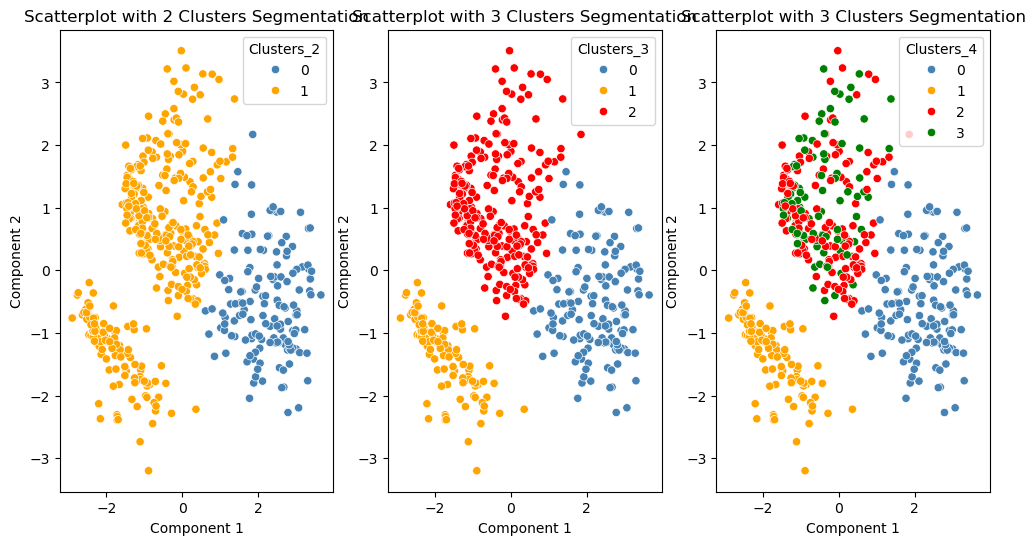

In [178]:
# Plotting
fig, ax = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(12, 6))

# Scatterplots
sns.scatterplot(data=df_plotting, x='Component 1', y='Component 2', hue='Clusters_2', 
                ax=ax[0], palette={0: 'steelblue', 1:'orange'})
ax[0].set_title('Scatterplot with 2 Clusters Segmentation')

sns.scatterplot(data=df_plotting, x='Component 1', y='Component 2', hue='Clusters_3', 
                ax=ax[1], palette={0: 'steelblue', 1:'orange', 2:'red'})
ax[1].set_title('Scatterplot with 3 Clusters Segmentation')

sns.scatterplot(data=df_plotting, x='Component 1', y='Component 2', hue='Clusters_4', 
                ax=ax[2], palette={0: 'steelblue', 1:'orange', 2:'red', 3:'green'})
ax[2].set_title('Scatterplot with 3 Clusters Segmentation')

plt.show()


It's quite clear that there appears to be 3 distinct type of customers in our dataset. Let's now take that and see what are the most common features of those customers of the 3-cluster segmentation.

In [194]:
df_modes = (
    df_clean
    .assign(
        Cluster = df['Clusters_3']
    )
    .groupby('Cluster', as_index=False)
    .apply(lambda x: x.mode().iloc[0]) 
)
df_modes

/var/folders/r8/_k88t7fn4sd2p6yz8zk526th0000gn/T/ipykernel_52553/4258716324.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.mode().iloc[0])


,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction,Cluster
0,20-35,Female,6 months to 1 year,Computer or laptop,Free (ad-supported),Yes,Duo plan- Rs 149/month,Podcast,classical,Afternoon,Uplifting and motivational,While Traveling,Radio,3,Once a week,Health and Fitness,Story telling,unknown Podcasters,Longer,Ok,0
1,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,No Preference or Willingness,Music,Melody,Night,Relaxation and stress relief,leisure time,recommendations,4,Never,Not a Podcast Listener,Not a Podcast Listener,Not a Podcast Listener,Not a Podcast Listener,Ok,1
2,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,No Preference or Willingness,Music,Melody,Night,Relaxation and stress relief,While Traveling,recommendations,4,Rarely,Comedy,Story telling,Both,Shorter,Ok,2


# Conclusion

So, what's the narrative? Well, let's break it down into the 3 segments to get a clear idea of our audience/customer base:

# --------------------------------------------------------
## Commonalities Across All Segments:
- They are all females with an age range of 20-35.
- They are all on the free, ad-supported, tier.
- They all seem relatively satisfied with the pod-cast variety, despite 1 of the clusters not identifying as podcast listeners.

# --------------------------------------------------------


# --------------------------------------------------------
## Segment 1:
- Have medium-duration usage (6 months to 1 year) and are usually listening on a computer or laptop.
- **There is some willingness to subscribe for the premium tier, so targeting this segment may prove to be profitable, versus the other two tiers that are not considering subscribing.**
- Is mostly a podcast listener
- Enjoy music while traveling that is uplifting and motivational, but prefers long-form podcasts with a story-telling narrative from smaller audience that are about health and fitness.

# --------------------------------------------------------


# --------------------------------------------------------
## Segment 2:
- Is a long-term user of Spotify
- Listens mostly on Smartphone, and is on the Free, ad-supported, tier with no willingless to subscribe.
- Mostly enjoys relaxing music at night during their free time.
- Make heavy use of the recommendation engine and is overall satisfied with the music recommendations. 
- Not a podcast listener

# --------------------------------------------------------



# --------------------------------------------------------

## Segment 3:
- Despite our clustering, segment 2 and 3 are relatively similar, but with 1 distinct difference.
- Instead of listening to music during free-time, this segment listens while traveling.
- Additionally, instead of not being a podcast listener at all, this segment does listen to podcasts sometimes (though Rarely)
- The podcasts are short-form comedy podcasts hosted by a mix of large-and-small audiences that embedd story-telling into it.
# --------------------------------------------------------